In [4]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from torch import nn
import torch
import jieba
import csv
from collections import defaultdict
from gensim.models import Word2Vec
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [6]:
# 停用词
stopwords = set()
with open('stopwords.txt', 'r', encoding='utf-8') as sw_file:
    for line in sw_file:
        stopwords.add(line.strip())

# 读取文件并分词
def read_and_segment(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        # print(content)
        jieba.load_userdict("self_define_dict.txt")
        seg_list = jieba.cut(content, cut_all=True)
        filtered_seg_list = [word for word in seg_list if word not in stopwords and len(word) >1]
        return list(filtered_seg_list)

# 构建词汇表，并统计词频
def build_vocab(seg_list):
    vocab = defaultdict(int)
    for word in seg_list:
        if len(word) > 0: 
            vocab[word] += 1
            
    return vocab  

# 训练Word2Vec模型
def train_word2vec(seg_list, vocab, size=100, window=5, min_count=1, workers=4):  
    sentences = [[word for word in line if word in vocab] for line in [seg_list]]  # 将分词列表转换为Gensim所需的格式
    model = Word2Vec(sentences, window=window, min_count=min_count, workers=workers)
    return model

# 读取文件并分词
seg_list = read_and_segment('盐铁论全文.txt')  

# 构建词汇表
vocab = build_vocab(seg_list)

# 训练Word2Vec模型
model = train_word2vec(seg_list, vocab)

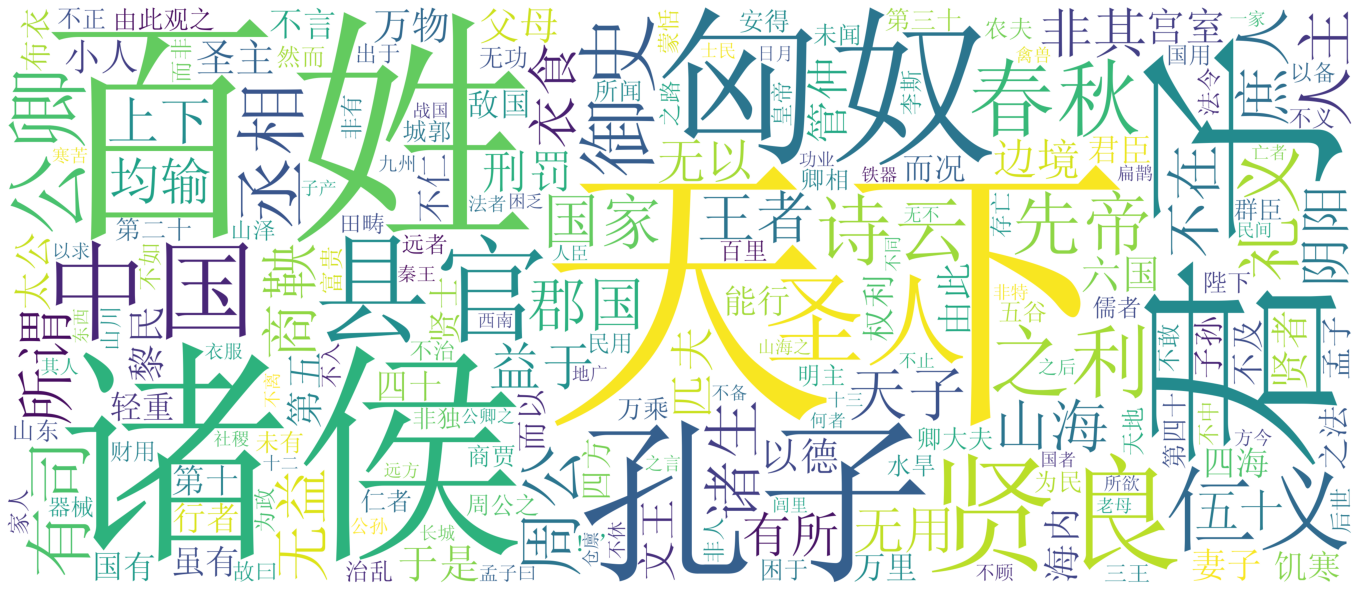

In [6]:
# 生成词云
font_path = 'simsun.ttf'
def generate_wordcloud(vocab):
    # 提取词汇和它们的频率
    words_and_freq = vocab.items()
    # 将词汇和频率转换为wordcloud所需的格式
    wordcloud_text = ' '.join([word for word, freq in words_and_freq])
    # 创建词云对象
    wordcloud = WordCloud(width=3500, height=1500, background_color='white',font_path =font_path, min_font_size=10).generate_from_frequencies(vocab)
    # 显示词云
    plt.figure(figsize=(20, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    # 保存词云图到文件  
    plt.savefig('worldcloud_chinese_0908.png', dpi=100, bbox_inches='tight')  # dpi参数用于设置分辨率，bbox_inches用于裁剪空白边缘
    # 显示图像  
    plt.show()
# 调用函数生成词云  
generate_wordcloud(vocab)

In [14]:
from matplotlib.font_manager import FontProperties  
  
font = FontProperties(fname='simsun.ttf', size=20)
font_min = FontProperties(fname='simsun.ttf', size=8)
# 绘制词频柱状图
def plot_word_freq_bar(vocab):
    # 提取词频最高的前N个词（这里选择前10个）
    top_words = sorted(vocab.items(), key=lambda x: x[1], reverse=True)[:25]
    words, freq = zip(*top_words)

    plt.figure(figsize=(20,6))  
    plt.bar(words, freq, color='orange')
    plt.title('Yantie Lun (盐铁论) word frequency', fontproperties=font)  
    # plt.xlabel('词汇', fontproperties=font)  
    # plt.ylabel('词频', fontproperties=font)
    plt.xticks(rotation=45)  # 防止标签重叠
    # 为x轴上的每一个刻度标签设置字体  
    for label in plt.gca().xaxis.get_ticklabels():  
        label.set_fontproperties(font)  # 设置字体属性
    plt.savefig('wordFreqBar_Chinese_0908.png', dpi=150, bbox_inches='tight')
    plt.show()
    

# 绘制词频饼状图  
def plot_word_freq_pie(vocab):
    # 计算所有词的总频率
    total_freq = sum(vocab.values())
    # 提取词频最高的前N个词（这里选择前10个）
    top_words = sorted(vocab.items(), key=lambda x: x[1], reverse=True)[:5000]  
    words, freq = zip(*top_words)  
    # 归一化词频  
    normalized_freq = [f / total_freq for f in freq]  
  
    plt.figure(figsize=(8, 8))  
    plt.pie(normalized_freq, labels=words, autopct='%1.1f%%', startangle=90)  
    plt.title('词频分析饼状图')  
    plt.axis('equal')  # 保证饼图是圆的  
    plt.show()  
    
# 调用函数绘制柱状图和饼状图  
# plot_word_freq_bar(vocab)  
# plot_word_freq_pie(vocab)

In [13]:
import numpy as np
import seaborn as sns
import warnings  
warnings.filterwarnings('ignore')  # 忽略所有警告


In [15]:
from sklearn.decomposition import PCA
# 定义各类词汇的Python列表  
defense_related = [  
    '障塞', '烽燧', '屯戍', '边费', '执备', '兵革', '干戈', '寇虏','边境','边寇','边'
    # , '敌国'  
]  
  
ethnic_groups = [  
    '匈奴', '单于', '胡', '朝鲜', '百越', '东越','西域','羌'  
]
  
geography_and_cities = [  
    '大都', '名都', '城郭', '市朝', '市井', '官市', '肆'  
]  
  
currency_and_wealth = [  
    '宝货', '委财', '玄贝', '紫石', '金钱刀币', '龟贝金钱', '白金龟龙', '货财', '货物', '币物', '方物', '贡输', '委府', '府库', '仓廪'  
]  
  
agriculture_and_livestock = [  
    '农业', '稼穑', '粮食', '五谷', '菽粟', '菽藿', '粟米', '桑麻', '桑榆菜果', '蚕麻', '麻枲', '农用', '铁器', '鉏', '鉏耰', '耒', '耜', '耨', '臿', '井田', '田畴', '南亩', '赤地', '唐园', '火耕', '水耨', '沟渠', '锄耘', '燔莱', '六畜', '刍豢', '骖', '骐骥', '牸牝', '犀象', '驹犊', '骡驴馲驼', '驒騱騵马', '华骝'  
]  
  
resources_and_crafts = [  
    '黄金', '金银', '白金', '金炉', '金斧', '金铜', '铁', '铁官', '铁器', '铁炭', '赋铁', '铁石', '盐铁丞', '铁镳', '铁力', '鼓铸', '镕铸', '销炼', '布', '帛', '丝', '丝絮', '练', '缣', '罗纨', '文缯', '绨', '素绨', '冰锦', '布褐', '麻枲', '缊袍', '皮裘', '文绣', '黼黻', '凫翁', '纨袴'  
]  
  
food_and_drink = [  
    '冠', '皮冠', '危冠', '冕', '麻冕', '韦沓', '不借', '粺饭', '白饭', '鲜肴', '甘毳', '饪', '糟糠', '箪食豆羹', '蔬粝荤茹', '馈', '觞酒豆肉', '朐卤', '醇酒'  
]  
  
architecture_and_transport = [  
    '茅茨', '蒿庐', '廛里', '马厩', '椽', '舟', '牛车', '舟楫', '安车', '辂', '辔衔', '维楫', '辎軿', '街衢', '关梁', '栈阁', '漕运', '楠梓竹箭', '鱼盐旃裘', '漆丝絺纻'  
]  
  
government_and_society = [  
    '编户齐民', '秦人', '周公', '外国', '中国', '汉', '汉国', '汉家', '汉兵', '社稷', '九州', '宇内', '神州', '天子', '王者', '陛下', '诏书', '舆服', '苑囿', '庙堂', '察廉', '选举', '方正', '六卿', '九卿', '贤良', '文学', '进士', '少府', '诸侯', '食邑', '爵禄']

In [16]:
import jieba  
from collections import defaultdict  
from gensim.models import Word2Vec  
import matplotlib.pyplot as plt  

# 读取文件并分词，同时记录位置  
def read_and_segment(file_path):  
    with open(file_path, 'r', encoding='utf-8') as f:  
        lines = f.readlines()  
        jieba.load_userdict("self_define_dict.txt")  
        seg_list_with_pos = []  
        sentence_num = 0  
        for line_num, line in enumerate(lines):  
            sentences = jieba.cut(line, cut_all=True)  
            for word in sentences:  
                if word not in stopwords and len(word) > 0:  
                    seg_list_with_pos.append((word, line_num, sentence_num))  
            sentence_num += 1
        return seg_list_with_pos
# 构建词汇表，并统计词频和位置
def build_vocab(seg_list_with_pos,select_words):
    vocab = defaultdict(int)
    defense_related_positions = defaultdict(list)
    for word, line_num, sentence_num in seg_list_with_pos:
        vocab[word] += 1
        if word in select_words:
            defense_related_positions[(line_num, sentence_num)].append(word)
    return vocab, defense_related_positions

# 读取文件并分词  
seg_list_with_pos = read_and_segment('盐铁论全文.txt')  

# 构建词汇表并分类统计  
vocab, defense_related_positions = build_vocab(seg_list_with_pos,defense_related)  

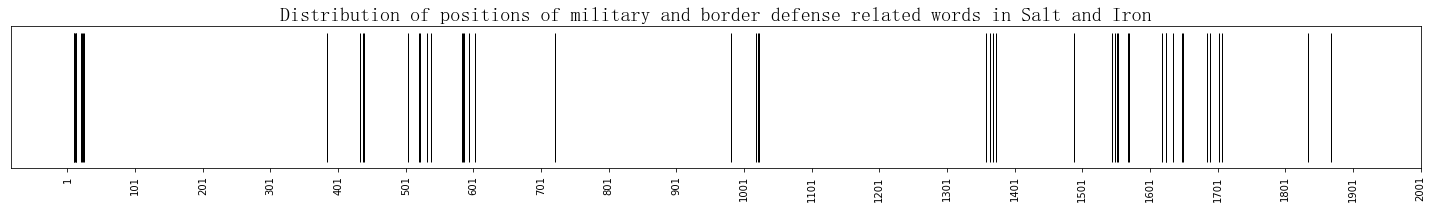

In [18]:
unique_positions = sorted(list(set([p[0] for p in defense_related_positions])))  # 提取唯一行号并排序  
  
# 假设文本总共有2096行  
total_lines = 2096  
  
# 创建一个图形，并设置合适的大小  
plt.figure(figsize=(20, 3))  
  
# 绘制垂直线，在每条“军事”类词汇出现的行上  
for position in unique_positions:  
    plt.vlines(x=position, ymin=0, ymax=1, colors='black', linewidths=1)  # 红色细线，从y=0到y=1  
# 设置x轴的刻度以匹配文本的行数  
plt.xticks(range(0, total_lines+1, 100),  # 可以根据需要调整步长  
           [f"{i+1}" for i in range(0, total_lines+1, 100)],  # 标签只显示每100行的行号  
           rotation=90)  # 旋转x轴标签以便更好地显示  
plt.yticks([])  # 添加这一行来去除y轴刻度
  
# 设置图形标题和轴标签  
# plt.title('军事边防相关词原文位置分布',fontproperties=font)  
plt.title('Distribution of positions of military and border defense related words in Salt and Iron',fontproperties=font)  

# plt.xlabel('positions in Salt and Iron',fontproperties=font_min)  
# plt.ylabel('Defense-Related Words Presence (Indicated by Vertical Lines)')  
# plt.savefig('defense出现位置分布_0831.png', dpi=150, bbox_inches='tight')

# 显示图形  
plt.tight_layout()  # 确保标签不会与图形重叠  
plt.show()

In [19]:
# 构建词汇表并分类统计  
vocab, ethnic_groups_positions = build_vocab(seg_list_with_pos,ethnic_groups) 
ethnic_groups_positions

defaultdict(list,
            {(9, 9): ['匈奴'],
             (18, 18): ['匈奴'],
             (20, 20): ['匈奴'],
             (75, 75): ['胡'],
             (76, 76): ['羌', '匈奴'],
             (214, 214): ['百越'],
             (223, 223): ['胡'],
             (224, 224): ['匈奴'],
             (227, 227): ['胡', '单于'],
             (231, 231): ['胡'],
             (266, 266): ['胡'],
             (270, 270): ['胡'],
             (407, 407): ['胡'],
             (444, 444): ['胡', '匈奴'],
             (529, 529): ['百越', '羌', '胡'],
             (534, 534): ['胡'],
             (583, 583): ['胡'],
             (585, 585): ['胡'],
             (589, 589): ['胡'],
             (598, 598): ['匈奴'],
             (599, 599): ['胡'],
             (604, 604): ['东越', '朝鲜'],
             (889, 889): ['匈奴'],
             (981, 981): ['匈奴'],
             (1060, 1060): ['胡'],
             (1081, 1081): ['胡'],
             (1220, 1220): ['胡'],
             (1222, 1222): ['胡', '胡'],
             (1366, 1366): ['胡'],
       

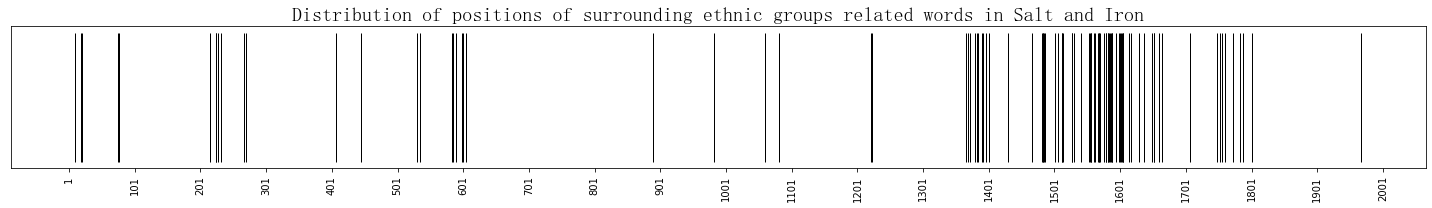

In [29]:
unique_positions = sorted(list(set([p[0] for p in ethnic_groups_positions])))  # 提取唯一行号并排序  

total_lines = 2096  
  
# 创建一个图形，并设置合适的大小  
plt.figure(figsize=(20, 3))  
  
# 绘制垂直线，在每条“军事”类词汇出现的行上  
for position in unique_positions:  
    plt.vlines(x=position, ymin=0, ymax=1, colors='black', linewidths=1)  # 红色细线，从y=0到y=1  
# 设置x轴的刻度以匹配文本的行数  
plt.xticks(range(0, total_lines+1, 100),  # 可以根据需要调整步长  
           [f"{i+1}" for i in range(0, total_lines+1, 100)],  # 标签只显示每100行的行号  
           rotation=90)  # 旋转x轴标签以便更好地显示  
plt.yticks([])  # 添加这一行来去除y轴刻度
  
# 设置图形标题和轴标签  
plt.title('Distribution of positions of surrounding ethnic groups related words in Salt and Iron',fontproperties=font)  
# plt.xlabel('原文行数',fontproperties=font_min)  
# plt.ylabel('Defense-Related Words Presence (Indicated by Vertical Lines)')  
# plt.savefig('周边民族相关词分布0901.png', dpi=120, bbox_inches='tight')

# 显示图形  
plt.tight_layout()  # 确保标签不会与图形重叠  
plt.show()

In [30]:
# 构建词汇表并分类统计  
vocab, agriculture_and_livestock_positions = build_vocab(seg_list_with_pos, agriculture_and_livestock) 
agriculture_and_livestock_positions

defaultdict(list,
            {(8, 8): ['农业'],
             (24, 24): ['粮食'],
             (28, 28): ['农用', '农用'],
             (32, 32): ['菽粟'],
             (39, 39): ['农用'],
             (66, 66): ['南亩'],
             (68, 68): ['田畴'],
             (70, 70): ['稼穑'],
             (77, 77): ['驒騱騵马'],
             (87, 87): ['井田'],
             (92, 92): ['井田'],
             (104, 104): ['燔莱', '火耕', '水耨'],
             (107, 107): ['田畴'],
             (108, 108): ['稼穑'],
             (116, 116): ['鉏'],
             (120, 120): ['犀象'],
             (133, 133): ['蚕麻'],
             (190, 190): ['五谷'],
             (191, 191): ['铁器'],
             (192, 192): ['五谷'],
             (195, 195): ['铁器'],
             (202, 202): ['铁器'],
             (206, 206): ['铁器'],
             (214, 214): ['粮食'],
             (330, 330): ['耒'],
             (338, 338): ['稼穑'],
             (480, 480): ['粟米', '桑榆菜果'],
             (482, 482): ['南亩', '麻枲'],
             (483, 483): ['麻枲'],
             (523

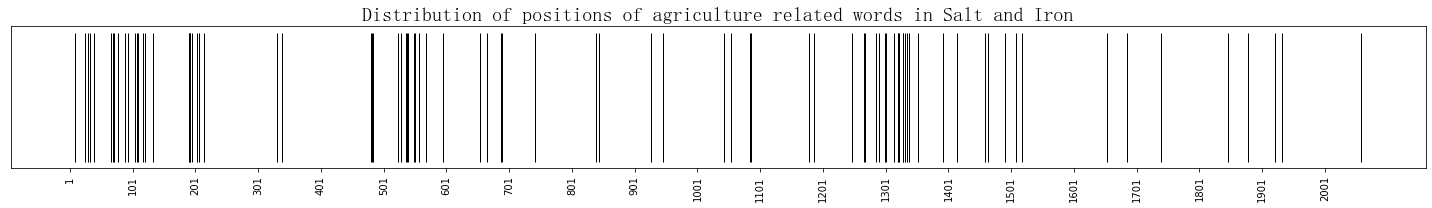

In [31]:
unique_positions = sorted(list(set([p[0] for p in agriculture_and_livestock_positions])))  # 提取唯一行号并排序  

total_lines = 2096

# 创建一个图形，并设置合适的大小  
plt.figure(figsize=(20, 3))  

# 绘制垂直线，在每条“军事”类词汇出现的行上  
for position in unique_positions:  
    plt.vlines(x=position, ymin=0, ymax=1, colors='black', linewidths=1)  # 红色细线，从y=0到y=1  
# 设置x轴的刻度以匹配文本的行数  
plt.xticks(range(0, total_lines+1, 100),  # 可以根据需要调整步长  
           [f"{i+1}" for i in range(0, total_lines+1, 100)],  # 标签只显示每100行的行号  
           rotation=90)  # 旋转x轴标签以便更好地显示  
plt.yticks([])  # 添加这一行来去除y轴刻度
  
# 设置图形标题和轴标签  
plt.title('Distribution of positions of agriculture related words in Salt and Iron',fontproperties=font)  
# plt.xlabel('原文行数',fontproperties=font)  
# plt.ylabel('Defense-Related Words Presence (Indicated by Vertical Lines)')  
plt.savefig('农牧生产相关词分布0901.png', dpi=150, bbox_inches='tight')

# 显示图形  
plt.tight_layout()  # 确保标签不会与图形重叠  
plt.show()

In [32]:
government_and_society = [  
    '编户齐民', '秦人', '周公', '外国', '中国', '汉', '汉国', '汉家', '汉兵', '社稷', '九州', '宇内', '神州', '天子', '王者', '陛下', '诏书', '舆服', '苑囿', '庙堂', '察廉', '选举', '方正', '六卿', '九卿', '贤良', '文学', '进士', '少府', '诸侯', '食邑', '爵禄']
confusion = ['周公','贤良', '文学', '仁义','圣人','君子','贤人','孔子','孟子','文王','礼义','尧','舜','禹','德教']

In [33]:
# 构建词汇表并分类统计  
vocab, confusion_positions = build_vocab(seg_list_with_pos,confusion) 
confusion_positions

defaultdict(list,
            {(2, 2): ['贤良'],
             (14, 14): ['孔子'],
             (15, 15): ['仁义'],
             (22, 22): ['孔子'],
             (32, 32): ['礼义'],
             (38, 38): ['圣人'],
             (43, 43): ['舜'],
             (61, 61): ['禹'],
             (62, 62): ['禹'],
             (67, 67): ['禹'],
             (73, 73): ['舜'],
             (80, 80): ['君子'],
             (89, 89): ['圣人'],
             (93, 93): ['禹'],
             (125, 125): ['孔子'],
             (130, 130): ['尧'],
             (133, 133): ['孟子'],
             (148, 148): ['礼义', '君子'],
             (216, 216): ['仁义'],
             (218, 218): ['贤良'],
             (224, 224): ['文王'],
             (253, 253): ['周公'],
             (256, 256): ['尧', '舜'],
             (280, 280): ['君子'],
             (284, 284): ['尧', '舜'],
             (303, 303): ['孔子'],
             (304, 304): ['孔子'],
             (305, 305): ['君子'],
             (306, 306): ['君子'],
             (307, 307): ['舜', '禹'],
           

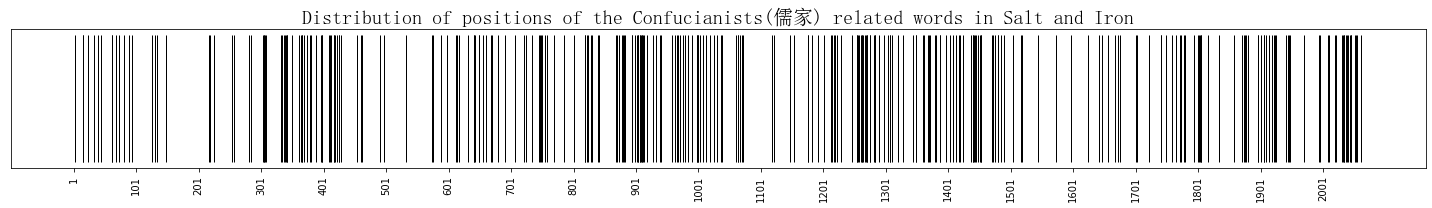

In [38]:
unique_positions = sorted(list(set([p[0] for p in confusion_positions])))  # 提取唯一行号并排序  

total_lines = 2096  
  
# 创建一个图形，并设置合适的大小  
plt.figure(figsize=(20, 3))  
  
# 绘制垂直线，在每条“军事”类词汇出现的行上  
for position in unique_positions:  
    plt.vlines(x=position, ymin=0, ymax=1, colors='black', linewidths=1)  # 红色细线，从y=0到y=1  
# 设置x轴的刻度以匹配文本的行数  
plt.xticks(range(0, total_lines+1, 100),  # 可以根据需要调整步长  
           [f"{i+1}" for i in range(0, total_lines+1, 100)],  # 标签只显示每100行的行号  
           rotation=90)  # 旋转x轴标签以便更好地显示  
plt.yticks([])  # 添加这一行来去除y轴刻度
  
# 设置图形标题和轴标签  
plt.title('Distribution of positions of the Confucianists(儒家) related words in Salt and Iron',fontproperties=font)  
# plt.xlabel('原文行数',fontproperties=font)  
# plt.ylabel('Defense-Related Words Presence (Indicated by Vertical Lines)')  
plt.savefig('儒家相关词分布0901.png', dpi=120, bbox_inches='tight')

# 显示图形  
plt.tight_layout()  # 确保标签不会与图形重叠  
plt.show()

In [27]:
law = ['商鞅', '李斯', '商君', '刑法', '重刑', '峭法', '盛刑', '峻法', '严刑', '刑罚', '韩非', '刑名', '苛法', '立法', '严法', '法度', '法治', '法令', '法禁', '法势','法家']
# 构建词汇表并分类统计  
vocab, law_positions = build_vocab(seg_list_with_pos,law) 
law_positions

defaultdict(list,
            {(178, 178): ['法禁'],
             (229, 229): ['李斯'],
             (236, 236): ['立法', '法度', '严刑', '刑罚'],
             (245, 245): ['商鞅'],
             (248, 248): ['商鞅'],
             (254, 254): ['商鞅'],
             (257, 257): ['商鞅', '重刑'],
             (270, 270): ['商鞅'],
             (271, 271): ['商鞅'],
             (281, 281): ['商鞅'],
             (294, 294): ['商鞅'],
             (508, 508): ['严法'],
             (658, 658): ['李斯'],
             (662, 662): ['李斯'],
             (670, 670): ['李斯'],
             (681, 681): ['刑法'],
             (686, 686): ['李斯'],
             (690, 690): ['李斯'],
             (693, 693): ['商鞅'],
             (694, 694): ['李斯'],
             (696, 696): ['商鞅', '李斯'],
             (721, 721): ['刑罚'],
             (852, 852): ['法令'],
             (865, 865): ['法令'],
             (881, 881): ['商鞅'],
             (883, 883): ['商鞅', '立法'],
             (884, 884): ['商鞅', '商鞅'],
             (892, 892): ['刑罚'],
             (89

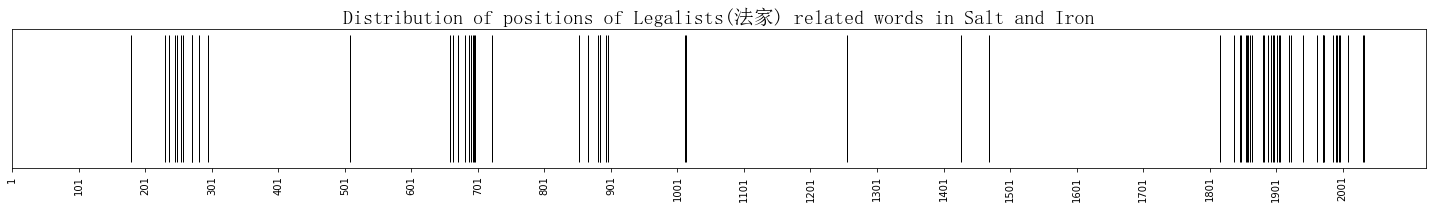

In [28]:
unique_positions = sorted(list(set([p[0] for p in law_positions])))  # 提取唯一行号并排序  

total_lines = 2096  
  
# 创建一个图形，并设置合适的大小  
plt.figure(figsize=(20, 3))  
  
# 绘制垂直线，在每条“军事”类词汇出现的行上  
for position in unique_positions:  
    plt.vlines(x=position, ymin=0, ymax=1, colors='black', linewidths=1)  # 红色细线，从y=0到y=1  
# 设置x轴的刻度以匹配文本的行数  
plt.xticks(range(0, total_lines+1, 100),  # 可以根据需要调整步长  
           [f"{i+1}" for i in range(0, total_lines+1, 100)],  # 标签只显示每100行的行号  
           rotation=90)  # 旋转x轴标签以便更好地显示  
plt.yticks([])  # 添加这一行来去除y轴刻度
  
# 设置图形标题和轴标签  
plt.title('Distribution of positions of Legalists(法家) related words in Salt and Iron',fontproperties=font)  
# plt.xlabel('原文行数',fontproperties=font)  
# plt.ylabel('Defense-Related Words Presence (Indicated by Vertical Lines)')  
plt.savefig('法家相关词分布0909.png', dpi=130, bbox_inches='tight')

# 显示图形  
plt.tight_layout()  # 确保标签不会与图形重叠  
plt.show()

In [41]:

country = ['中国','国家','社稷','九州','宇内','神州','汉']
# 构建词汇表并分类统计  
vocab, country_positions = build_vocab(seg_list_with_pos,country) 
country_positions

defaultdict(list,
            {(9, 9): ['中国'],
             (18, 18): ['中国'],
             (26, 26): ['国家'],
             (54, 54): ['汉'],
             (75, 75): ['汉'],
             (76, 76): ['中国'],
             (84, 84): ['汉'],
             (104, 104): ['汉'],
             (120, 120): ['中国'],
             (159, 159): ['汉'],
             (163, 163): ['汉'],
             (222, 222): ['国家'],
             (268, 268): ['国家'],
             (272, 272): ['社稷'],
             (311, 311): ['汉'],
             (325, 325): ['国家'],
             (348, 348): ['国家'],
             (398, 398): ['国家'],
             (435, 435): ['国家'],
             (441, 441): ['社稷', '九州'],
             (446, 446): ['中国'],
             (447, 447): ['宇内'],
             (448, 448): ['国家'],
             (477, 477): ['国家'],
             (497, 497): ['国家'],
             (520, 520): ['中国'],
             (522, 522): ['中国'],
             (523, 523): ['中国'],
             (532, 532): ['九州'],
             (584, 584): ['中国'],
         

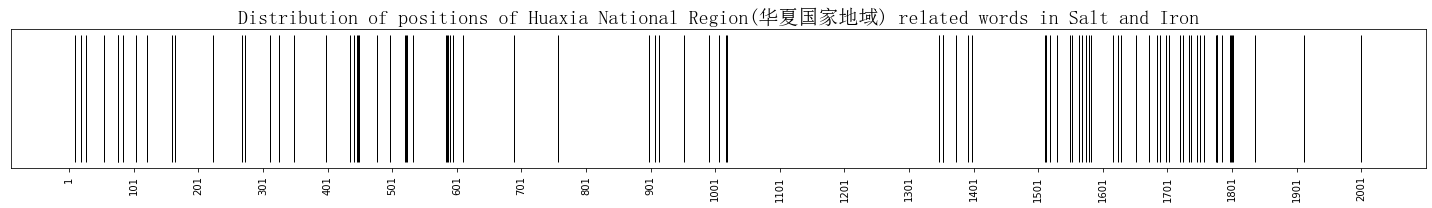

In [42]:
unique_positions = sorted(list(set([p[0] for p in country_positions])))  # 提取唯一行号并排序  

total_lines = 2096  
  
# 创建一个图形，并设置合适的大小  
plt.figure(figsize=(20, 3))  
  
# 绘制垂直线，在每条“军事”类词汇出现的行上  
for position in unique_positions:  
    plt.vlines(x=position, ymin=0, ymax=1, colors='black', linewidths=1)  # 红色细线，从y=0到y=1  
# 设置x轴的刻度以匹配文本的行数  
plt.xticks(range(0, total_lines+1, 100),  # 可以根据需要调整步长  
           [f"{i+1}" for i in range(0, total_lines+1, 100)],  # 标签只显示每100行的行号  
           rotation=90)  # 旋转x轴标签以便更好地显示  
plt.yticks([])  # 添加这一行来去除y轴刻度
  
# 设置图形标题和轴标签  
plt.title('Distribution of positions of Huaxia National Region(华夏国家地域) related words in Salt and Iron',fontproperties=font)  
# plt.xlabel('原文行数',fontproperties=font)  
# plt.ylabel('Defense-Related Words Presence (Indicated by Vertical Lines)')  
plt.savefig('国家地域相关词分布0901.png', dpi=120, bbox_inches='tight')

# 显示图形  
plt.tight_layout()  # 确保标签不会与图形重叠  
plt.show()

In [43]:
empire = ['天子','王者','陛下','诏书','庙堂','皇帝']
# 构建词汇表并分类统计  
vocab, empire_positions = build_vocab(seg_list_with_pos,empire) 
empire_positions

defaultdict(list,
            {(2, 2): ['诏书'],
             (15, 15): ['天子'],
             (17, 17): ['庙堂', '王者'],
             (19, 19): ['陛下'],
             (32, 32): ['王者'],
             (60, 60): ['王者'],
             (86, 86): ['王者'],
             (122, 122): ['王者'],
             (171, 171): ['王者'],
             (181, 181): ['天子'],
             (182, 182): ['天子', '天子'],
             (183, 183): ['王者'],
             (205, 205): ['陛下'],
             (213, 213): ['皇帝'],
             (215, 215): ['陛下'],
             (217, 217): ['陛下'],
             (334, 334): ['王者'],
             (369, 369): ['天子'],
             (427, 427): ['天子'],
             (433, 433): ['王者'],
             (440, 440): ['天子'],
             (441, 441): ['陛下'],
             (443, 443): ['陛下'],
             (466, 466): ['天子'],
             (529, 529): ['皇帝'],
             (550, 550): ['陛下'],
             (566, 566): ['陛下'],
             (576, 576): ['陛下'],
             (581, 581): ['王者'],
             (587, 587): ['天子

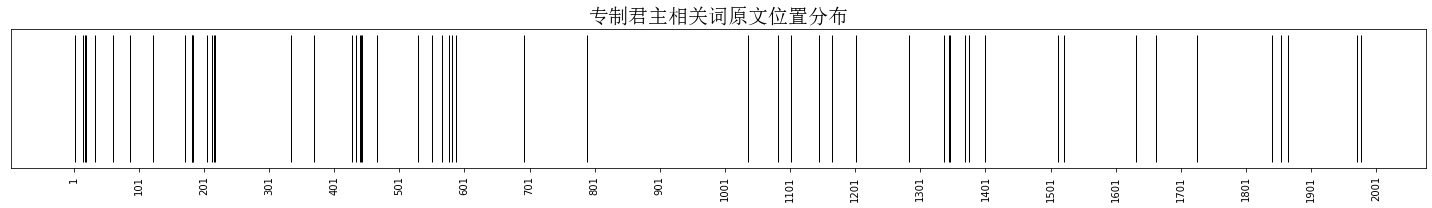

In [92]:
unique_positions = sorted(list(set([p[0] for p in empire_positions])))  # 提取唯一行号并排序  

total_lines = 2096  
  
# 创建一个图形，并设置合适的大小  
plt.figure(figsize=(20, 3))  
  
# 绘制垂直线，在每条“军事”类词汇出现的行上  
for position in unique_positions:  
    plt.vlines(x=position, ymin=0, ymax=1, colors='black', linewidths=1)  # 红色细线，从y=0到y=1  
# 设置x轴的刻度以匹配文本的行数  
plt.xticks(range(0, total_lines+1, 100),  # 可以根据需要调整步长  
           [f"{i+1}" for i in range(0, total_lines+1, 100)],  # 标签只显示每100行的行号  
           rotation=90)  # 旋转x轴标签以便更好地显示  
plt.yticks([])  # 添加这一行来去除y轴刻度
  
# 设置图形标题和轴标签  
plt.title('专制君主相关词原文位置分布',fontproperties=font)  
# plt.xlabel('原文行数',fontproperties=font)  
# plt.ylabel('Defense-Related Words Presence (Indicated by Vertical Lines)')  
plt.savefig('专制君主相关词分布.png', dpi=600, bbox_inches='tight')

# 显示图形  
plt.tight_layout()  # 确保标签不会与图形重叠  
plt.show()

In [44]:
economy = ['贡输','委府','府库','仓廪','煮盐','轻重','本末','末利','利孔','赋税','贡赋','繇赋','盐铁','酒榷','均输','山川之利','盐','铁','货殖']
# 构建词汇表并分类统计  
vocab, economy_positions = build_vocab(seg_list_with_pos,economy) 
economy_positions

defaultdict(list,
            {(4, 4): ['末利'],
             (5, 5): ['盐', '铁', '酒榷'],
             (8, 8): ['盐', '铁', '酒榷', '均输'],
             (11, 11): ['盐', '铁', '酒榷', '均输'],
             (12, 12): ['府库'],
             (20, 20): ['盐', '铁', '均输'],
             (25, 25): ['盐', '铁'],
             (26, 26): ['本末'],
             (29, 29): ['盐', '铁', '均输'],
             (40, 40): ['均输', '盐', '铁', '均输'],
             (45, 45): ['利孔'],
             (47, 47): ['贡输'],
             (48, 48): ['均输', '委府'],
             (50, 50): ['均输', '均输'],
             (51, 51): ['利孔'],
             (52, 52): ['赋税'],
             (58, 58): ['均输', '贡输'],
             (60, 60): ['轻重'],
             (64, 64): ['均输', '仓廪', '均输', '府库'],
             (74, 74): ['均输'],
             (75, 75): ['轻重'],
             (127, 127): ['末利'],
             (130, 130): ['本末'],
             (131, 131): ['盐'],
             (162, 162): ['煮盐'],
             (168, 168): ['轻重'],
             (175, 175): ['盐铁'],
             (176, 176

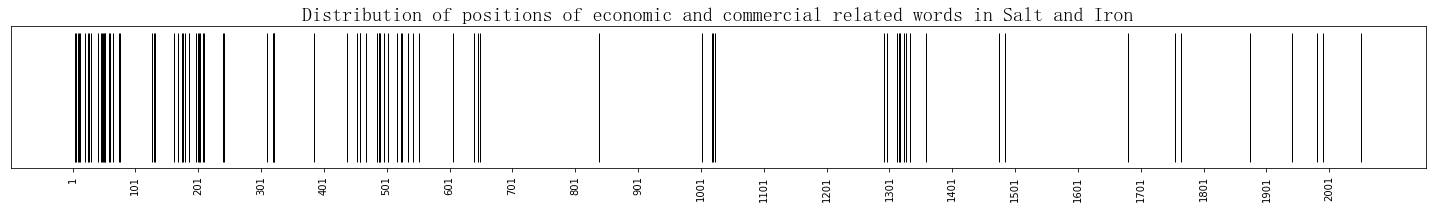

In [45]:
unique_positions = sorted(list(set([p[0] for p in economy_positions])))  # 提取唯一行号并排序  

total_lines = 2096  
  
# 创建一个图形，并设置合适的大小  
plt.figure(figsize=(20, 3))  
  
# 绘制垂直线，在每条“军事”类词汇出现的行上  
for position in unique_positions:  
    plt.vlines(x=position, ymin=0, ymax=1, colors='black', linewidths=1)  # 红色细线，从y=0到y=1  
# 设置x轴的刻度以匹配文本的行数  
plt.xticks(range(0, total_lines+1, 100),  # 可以根据需要调整步长  
           [f"{i+1}" for i in range(0, total_lines+1, 100)],  # 标签只显示每100行的行号  
           rotation=90)  # 旋转x轴标签以便更好地显示  
plt.yticks([])  # 添加这一行来去除y轴刻度
  
# 设置图形标题和轴标签  
plt.title('Distribution of positions of economic and commercial related words in Salt and Iron',fontproperties=font)  
# plt.xlabel('原文行数',fontproperties=font)  
# plt.ylabel('Defense-Related Words Presence (Indicated by Vertical Lines)')  
plt.savefig('经济商业相关词分布0901.png', dpi=120, bbox_inches='tight')

# 显示图形  
plt.tight_layout()  # 确保标签不会与图形重叠  
plt.show()